In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import pinocchio as pin
from pinocchio.rpy import matrixToRpy
import matplotlib.pyplot as plt
from adaptor import MotionAdaptor
import pickle

In [2]:
def makeT(Rot, trans):
    T = np.zeros([4, 4])
    for i in range(3):
        for j in range(3):
            T[i][j] = Rot[i][j]
        T[i][3] = trans[i]
    T[3][3] = 1
    return T

def makeTrans(x, y, z):
    trans = np.zeros([3, 1])
    trans[0] = x
    trans[1] = y
    trans[2] = z
    return trans

def makeR(x, y, z, w):
    R = np.zeros([3, 3])
    q0 = w
    q1 = x
    q2 = y
    q3 = z
    R[0][0] = q0*q0 + q1*q1 - q2*q2 - q3*q3
    R[0][1] = 2 * (q1*q2 - q0*q3)
    R[0][2] = 2 * (q0*q2 + q1*q3)
    R[1][0] = 2 * (q0*q3 + q1*q2)
    R[1][1] = q0*q0 - q1*q1 + q2*q2 - q3*q3
    R[1][2] = 2 * (q2*q3 - q0*q1)
    R[2][0] = 2 * (q1*q3 - q0*q2)
    R[2][1] = 2 * (q0*q1 + q2*q3)
    R[2][2] = q0*q0 - q1*q1 - q2*q2 + q3*q3
    return R

def frameTranslation(T01, T02):
    T12 = np.linalg.inv(T01) @ T02
    return T12

# def getXYZW(T):
#     temp = T[0][0] + T[1][1] + T[2][2] + 1
#     if(temp < 0) :
#       temp *= -1
#       temp = -1 * math.sqrt(temp)
#     w = 0.5 * temp
#     x = 0.25 * w * (T[2][1] - T[1][2])
#     y = 0.25 * w * (T[0][2] - T[2][0])
#     z = 0.25 * w * (T[1][0] - T[0][1])
#     return x, y, z, w

def getAngle(T):
    temp = T[0,0] * T[0][0] + T[1][0] * T[1][0]
    if(temp < 0) :
      temp *= -1
      temp = -1 * math.sqrt(temp)
    b = math.atan2(-T[2][0], temp)
    a = math.atan2(T[1][0], T[0][0])
    c = math.atan2(T[2][1], T[2][2])
    return a, b, c

In [3]:
#Test def
R01 = makeR(1,2,3,4)
trans01 = makeTrans(1,2,3)
T01 = makeT(R01, trans01)

R02 = makeR(5,6,7,8)
trans02 = makeTrans(4,5,6)
T02 = makeT(R02, trans02)

T12 = frameTranslation(T01, T02)
print(T12)
# x, y, z, w = getXYZW(T12)
# print("x = ", x, "y = ", x, "z = ", z, "w = ", w)
a, b, c = getAngle(T12)
print("a = ", a, "b = ", b, "c = ", c)

[[ 5.65777778 -1.24444444  0.28444444  0.07333333]
 [ 1.24444444  5.08888889 -2.48888889  0.03333333]
 [ 0.28444444  2.48888889  5.23111111  0.15333333]
 [ 0.          0.          0.          1.        ]]
a =  0.21650534768554558 b =  -0.00847572510466978 c =  0.4440893619729617


In [4]:
#load data from csv
path = 'elbow.xlsx'
forearm_data = pd.read_excel(path, sheet_name='forearm')

forearm_quat = []
for i in range(len(forearm_data.quat_w)):
    forearm_quat.append([forearm_data.quat_x[i], forearm_data.quat_y[i], forearm_data.quat_z[i], forearm_data.quat_w[i]])

forearm_pos = []
for i in range(len(forearm_data.pos_x)):
    forearm_pos.append([forearm_data.pos_x[i], forearm_data.pos_y[i], forearm_data.pos_z[i]])

In [5]:
rpy = []
quat0 = pin.Quaternion(np.matrix(forearm_quat[0]).T).normalized()
R0=quat0.toRotationMatrix()

for _quat in forearm_quat:
    quat = pin.Quaternion(np.matrix(_quat).T).normalized()
    R = quat.toRotationMatrix().dot(np.linalg.inv(R0))
    v = matrixToRpy(R)
    rpy.append(v)

Text(0, 0.5, 'elbow joint position [degree]')

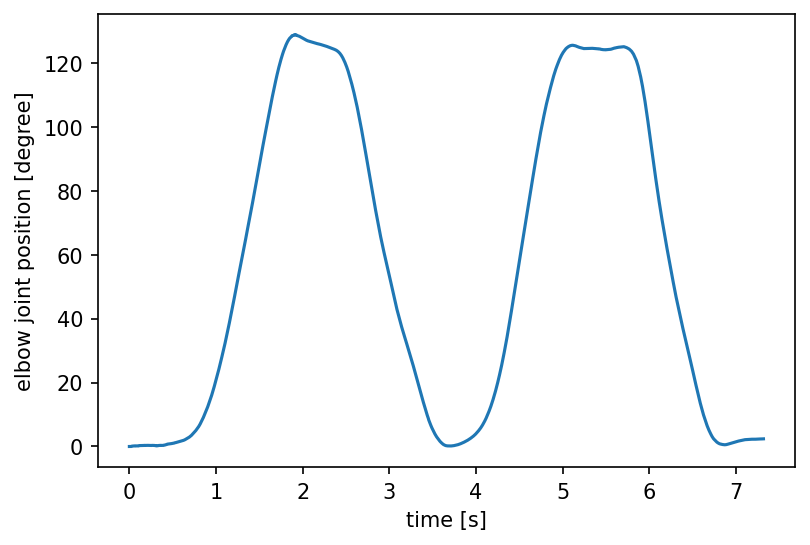

In [6]:
plt.figure(dpi=150)
# plt.plot(np.arange(len(rpy))/240.,[_rpy[0]/np.pi*180 for _rpy in rpy], label='x',  lw=2, c='r',alpha =0.8)
plt.plot(np.arange(len(rpy))/240.,[_rpy[0]/np.pi*180 for _rpy in rpy])
# plt.plot(np.arange(len(rpy))/240.,[_rpy[1]/np.pi*180 for _rpy in rpy], label='y', lw=2, c='g',alpha =.8)
# plt.plot(np.arange(len(rpy))/240.,[_rpy[2]/np.pi*180 for _rpy in rpy], label='z', lw=2, c='b',alpha =.8)
# plt.legend()
plt.xlabel('time [s]')
# plt.ylabel('Euler angles [degree]')
plt.ylabel('elbow joint position [degree]')

In [7]:
dt = 1/240.
T= len(rpy)
p_elbow = []
for i in range(T):
    p_elbow.append(rpy[i][0])
    
d_elbow = []
d_elbow.append(0.)
for i in range(1, T):
    v = (rpy[i][0]-rpy[i-1][0])/dt
    d_elbow.append(v)
dd_elbow = []
dd_elbow.append(0.)
for i in range(1, T):
    a = (d_elbow[i]-d_elbow[i-1])/dt
    dd_elbow.append(a)

Text(0, 0.5, 'elbow joint velocity[rad/s]')

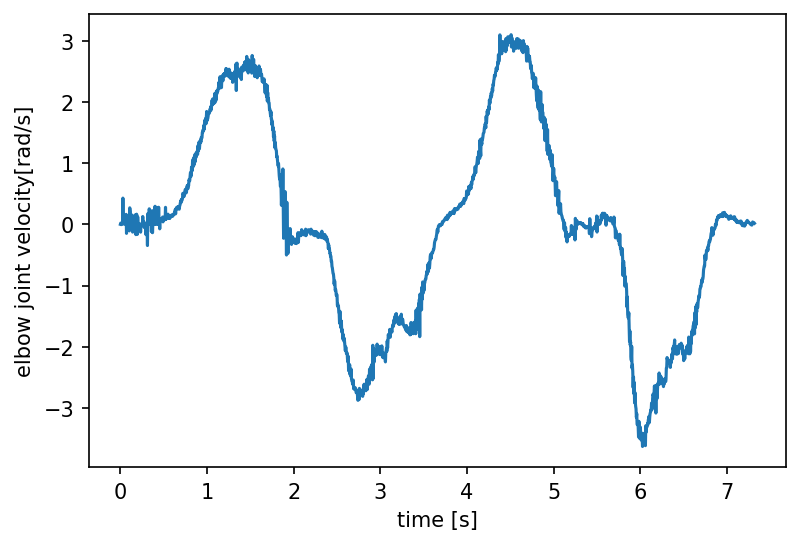

In [8]:
plt.figure(dpi=150)
plt.plot(np.arange(len(d_elbow))/240.,[d for d in d_elbow], label='dx')
# plt.plot(np.arange(len(rpy))/240.,[_rpy[0]/np.pi*180 for _rpy in rpy], label='x')
# plt.legend()
plt.xlabel('time [s]')
plt.ylabel('elbow joint velocity[rad/s]')

Text(0, 0.5, 'elbow joint velocity[radian/s^2]')

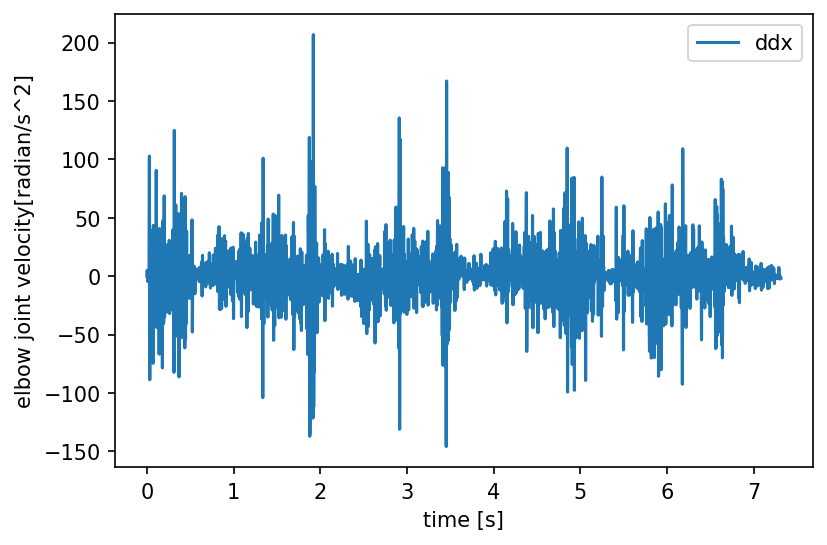

In [9]:
plt.figure(dpi=150)
plt.plot(np.arange(len(dd_elbow))/240.,[d for d in dd_elbow], label='ddx')
# plt.plot(np.arange(len(rpy))/240.,[_rpy[0]/np.pi*180 for _rpy in rpy], label='x')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('elbow joint velocity[radian/s^2]')

In [10]:
nj=1
q_ref = []
dq_ref = []
ddq_ref = []

for i in range(T):
    q_ = [p_elbow[i]]
    dq_ = [d_elbow[i]]
    ddq_ = [dd_elbow[i]]

    q_ref.append(np.array(q_))
    dq_ref.append(np.array(dq_))
    ddq_ref.append(np.array(ddq_))

In [11]:
motorAdaptor = MotionAdaptor(nj)
q = np.zeros(nj)
dq = np.zeros(nj)
q = q_ref[0].copy()
dq = dq_ref[0].copy()
print(q, dq)
if dq[0]> 2.5:
    dq[0] = 2.5
elif dq[0] <-2.5:
    dq[0] = -2.5

q_new = []
dq_new = []
ddq_new = []

for i in range(T):
    ddq = motorAdaptor.compute(q, dq, q_ref[i], dq_ref[i], ddq_ref[i])
    q_new.append(q.copy())
    dq_new.append(dq.copy())
    ddq_new.append(ddq.copy())
    q, dq = motorAdaptor.forward(q, dq, ddq)

[0.] [0.]


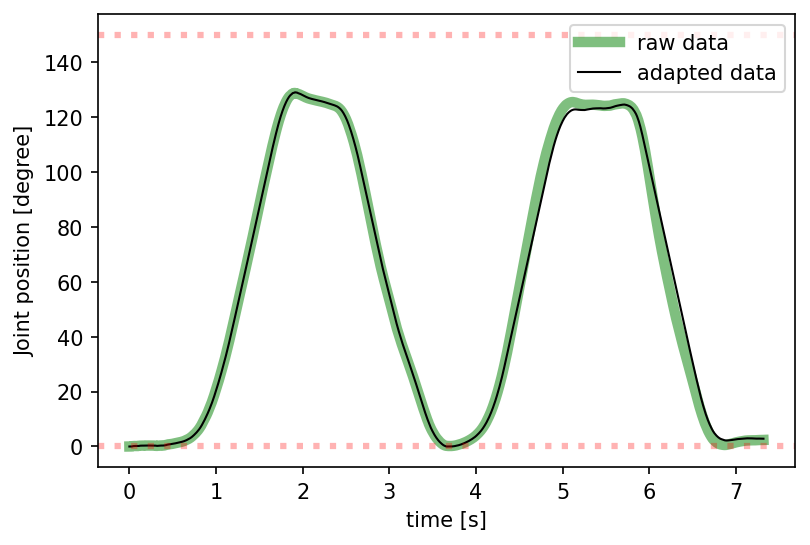

In [12]:
fig, ax = plt.subplots(dpi=150)
ax.plot(np.arange(len(q_ref))*dt, [q[0]/np.pi*180 for q in q_ref], label='raw data',lw=5, c='g',alpha =.5)
ax.plot(np.arange(len(q_ref))*dt, [q[0]/np.pi*180 for q in q_new], label='adapted data',lw=1, c='k')

plt.axhline(y=150., color='r', linestyle=':', lw = 3,alpha=.3)
plt.axhline(y=.0/np.pi*180, color='r', linestyle=':', lw = 3,alpha=.3)
ax.legend()
plt.ylabel('Joint position [degree]')
plt.xlabel('time [s]')
plt.show()

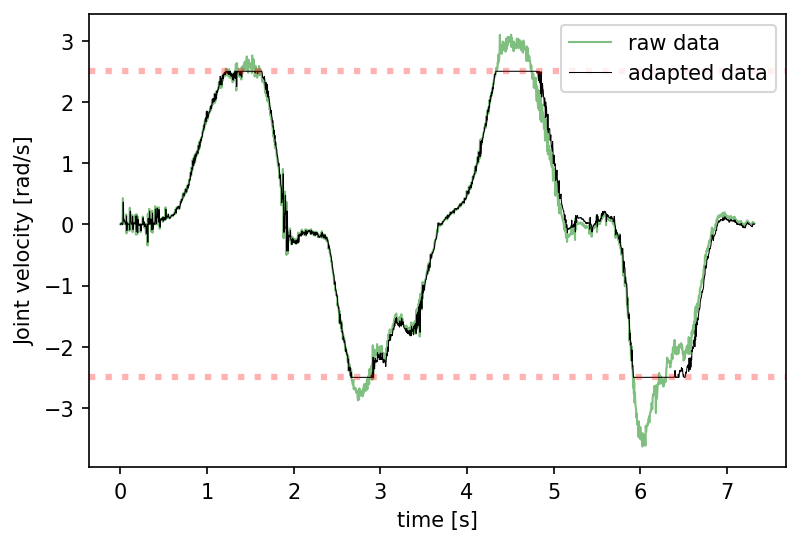

In [13]:
fig, ax = plt.subplots(dpi=150)
ax.plot(np.arange(len(q_ref))*dt, [dq[0] for dq in dq_ref], label='raw data',lw=1., c='g',alpha=0.5)
ax.plot(np.arange(len(q_ref))*dt, [dq[0] for dq in dq_new], label='adapted data',lw=.5, c='k')

plt.axhline(y=2.5, color='r', linestyle=':', lw = 3,alpha=.3)
plt.axhline(y=-2.5, color='r', linestyle=':', lw = 3,alpha=.3)
ax.legend(loc = "upper right")
plt.ylabel('Joint velocity [rad/s]')
plt.xlabel('time [s]')
plt.show()

In [14]:
with open('data.pickle', 'wb') as handle:
    pickle.dump(q_new, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
#load data from csv
path = 'elbow.xlsx'
upperarm_data = pd.read_excel(path, sheet_name='upperarm')

upperarm_quat = []
for i in range(len(upperarm_data.quat_w)):
    upperarm_quat.append([upperarm_data.quat_x[i], upperarm_data.quat_y[i], upperarm_data.quat_z[i], upperarm_data.quat_w[i]])

upperarm_pos = []
for i in range(len(upperarm_data.pos_x)):
    upperarm_pos.append([upperarm_data.pos_x[i], upperarm_data.pos_y[i], upperarm_data.pos_z[i]])

In [16]:
rpy = []
quat0 = pin.Quaternion(np.matrix(upperarm_quat[0]).T).normalized()
R0=quat0.toRotationMatrix()

for _quat in upperarm_quat:
    quat = pin.Quaternion(np.matrix(_quat).T).normalized()
    R = quat.toRotationMatrix().dot(np.linalg.inv(R0))
    v = matrixToRpy(R)
    rpy.append(v)

Text(0, 0.5, 'shoulder joint [degree]')

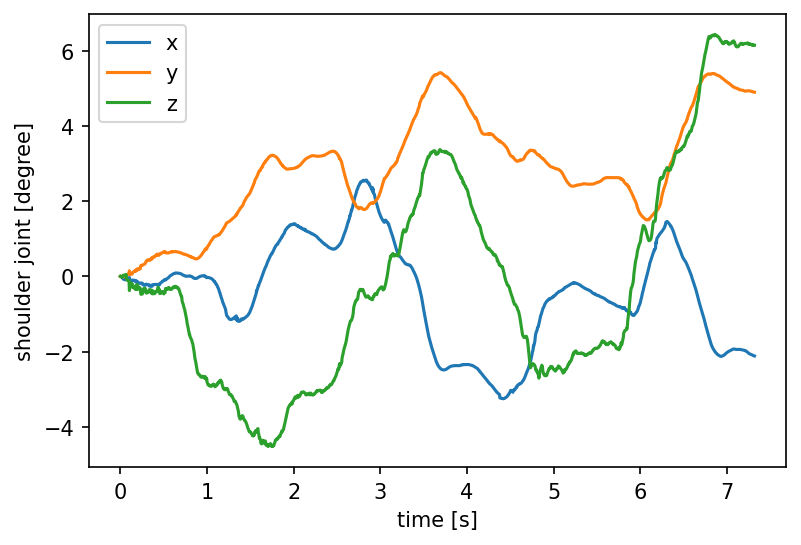

In [17]:
plt.figure(dpi=150)
plt.plot(np.arange(len(rpy))/240.,[_rpy[0]/np.pi*180 for _rpy in rpy], label='x')
plt.plot(np.arange(len(rpy))/240.,[_rpy[1]/np.pi*180 for _rpy in rpy], label='y')
plt.plot(np.arange(len(rpy))/240.,[_rpy[2]/np.pi*180 for _rpy in rpy], label='z')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('shoulder joint [degree]')